# GROUP 35 - STAT 301 FINAL REPORT

### Group member:
- Doris Che (33996984)
- Eric Kim (87743738)
- Naufal Prasojo (14303440)
- Isaiah Nitin (79496493)


### **2. INTRODUCTION**


We are interested to understand which listing characteristics (e.g `price`, `superhost`, etc) and location-based features (e.g `dist`, `metro_dist`, `attr_index_n`, etc) are most strongly associated with higher or lower Airbnb's `guest_satisfaction` in Athens. Our reponse variable will be `guest_satisfaction`, representing the overall guest satisfaction level of the Airbnb listing in Athens. Our question is focused on inference, as we are investing the association between the response and explanatory variables. We are not using the explanatory variables to predict what the satisfaction rating of an arbitrary listing may be.

### **3. Methods and Results**

### A) Data

**1.1 Data Summary**
- **Dataset Name:** Airbnb Prices in European Cities
- **Source:** Kaggle dataset by The Devastator (2021). Available at
https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities
- **License:** CC BY-NC 4.0 (Attribution-NonCommercial).
- **Data Collection:** Listings were web-scraped from Airbnb for 10 European cities (Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna), but for this assignment we only use Athens data.
     - Each city has two files (weekday and weekend) capturing snapshot prices for 2-night stays for two guests.
     - Approx. 2627~2653 observations (rows) and 19 variables (columns).

**1.2 Source and Information**

The data were collected by web-scraping Airbnb public listings around 2020–2021 by The Devastator. The author compiled cleaned CSV files for each city and time category (weekday vs weekend) and license as CC BY-NC 4.0 (Attribution-NonCommercial).

**1.3 Pre-Selection of Variables**

- Variables to keep: `guest_satisfaction_overall` (as response variable), `realSum`, `superhost`, `cleanliness_rating`, `dist`, `metro_dist`, `attr_index_norm`, `rest_index_norm`.

Reasoning: These variables seem most useful for both understanding factors for Airbnb prices or for building a model that can help estimate fair prices for future listings in Athens.

- Variables to drop (initial cleaning phase):

    - `room_type` - reflects a guest’s functional need rather than overall satisfaction, so it’s not a meaningful explanatory variable for rating differences.
    - `person_capacity` - highly correlated with other size-related features but adds little/none independent information for satisfaction.
    - `weekday/weekend` - categorical timing variable that might not relevant with overall satisfaction.
    - `lng`, `lat` – spatial coordinates does not needed for non-map models (but can be added later for spatial EDA).
    - `attr_index`, `rest_index` – very similar with normalized versions and may introduce redundancy.
    - `multi`, `biz` – may be reintroduced if host type becomes an interest variable, but initial models will focus on inference model for price.
    - `room_shared`, `room_private` – these indicators are redundant with `room_type`, so I will not include.

Reasoning: Variables dropped contain redundant or identifier information not directly useful for predictive or interpretive modelling. All decisions will be re-evaluated after EDA.

----------

### B) Exploratory Data Analysis

In [1]:
library(tidyverse)
library(broom)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
#Read data into a datafram in R
athens_weekday_df <- read.csv("data/athens_weekdays.csv") %>% 
    mutate (is_weekend = 0)%>%
    select(guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend)

#Read data into a datafram in R
athens_weekend_df <- read.csv("data/athens_weekends.csv") %>% 
    mutate (is_weekend = 1)%>% 
    select(guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend)

# Cleaning data: removing nonsense outliers
"number obeservations for realSum >= 10000: "
nrow(athens_weekdays_df[fathens_weekdays$realSum >= 10000, ])

athens_weekdays_clean <- athens_weekdays %>% filter(realSum < 10000)
summary(athens_weekdays_clean$guest_satisfaction_overall)

athens_weekends_clean <- athens_weekends %>% filter(realSum < 10000)
summary(athens_weekends_clean$guest_satisfaction_overall)

# Combine datasets for comparison plots + add binary period column
athens <- bind_rows(
  athens_weekdays_clean %>% mutate(period = "Weekday"),
  athens_weekends_clean %>% mutate(period = "Weekend")
) %>%
  mutate(period = factor(period, levels = c("Weekday","Weekend")))

head(athens)

[1] "number obeservations for realSum >= 10000: "

ERROR: Error in eval(expr, envir, enclos): object 'athens_weekdays' not found


In [ ]:
# Visualizing the distribution of guest_satisfaction_overall for weekdays and weekends

distribution_satisfaction_weekends <- ggplot(athens_weekends_clean, aes(x = guest_satisfaction_overall)) +
    geom_histogram(bins = 30, fill = "orange", color = "white") +
    labs(title = "Distribution of Airbnb Guest Satisfaction in Athens on weekends",
        x = "Guest Satisfaction Overall",
        y = "Count") +
    theme_minimal()

distribution_satisfaction_weekdays <- ggplot(athens_weekdays_clean, aes(x = guest_satisfaction_overall)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "white") +
    labs(title = "Distribution of Airbnb Guest Satisfaction in Athens on weekdays",
        x = "Guest Satisfaction Overall",
        y = "Count") +
    theme_minimal()

distribution_satisfaction_combine <- ggplot(athens, aes(x = guest_satisfaction_overall, fill = period, color = period)) +
  geom_histogram(position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Airbnb Guest Satisfaction in Athens",
        x = "Guest Satisfaction Overall",
        y = "Count") +
  scale_fill_brewer(palette = "Set2") +
  scale_color_brewer(palette = "Set2")

In [ ]:
satis_double_dist_plot <- ggplot(athens, aes(x = dist, y = metro_dist, z = guest_satisfaction_overall)) +
  stat_summary_2d(fun = mean, bins = 6) +
  scale_fill_viridis_c(option = "C") +
  labs(title = "Mean Guest Satisfaction by Distance and Metro Distance",
       x = "Distance to City Centre (km)", y = "Distance to Metro (km)",
       fill = "Mean Guest Satisfaction") +
  theme_minimal()

satis_double_index_plot <- ggplot(athens, aes(x = attr_index_norm, y = rest_index_norm, z = guest_satisfaction_overall)) +
  stat_summary_2d(fun = mean, bins = 4) +
  scale_fill_viridis_c(option = "C") +
  labs(title = "Mean Guest Satisfaction by Attractiveness and Restaurant Index",
       x = "Attractiveness Index (normalized)", y = "Restaurant Index (normalized)",
       fill = "Mean Guest Satisfaction") +
  theme_minimal()

athens_combined_plot <- athens |>
    ggplot(aes(x = realSum, y = guest_satisfaction_overall, color = host_is_superhost)) +
           geom_point() +
           geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.7) +
           ggtitle("Guest Satisfaction Overall vs Price of Listing of Airbnb in Athens") +
           xlab("Price of Listing (Euros)") +
           ylab("Guest Satisfaction Overall") +
           labs(color = "Superhost")

options(repr.plot.width = 16, repr.plot.height = 15)
plot_grid(distribution_satisfaction_weekends, distribution_satisfaction_weekdays,
          distribution_satisfaction_combine, athens_combined_plot,
          satis_double_dist_plot, satis_double_index_plot,
          ncol = 2)

### C) Methods: Plan

We will be using three linear models;

1. **Simple Linear Regression** 
    * Model: guest_satisfaction_overall ~ realSum
    * Justification: The SLR baseline model will allow us to establish the association between price and guest satisfaction helping us see if higher prices correlate with guest         satisfaction before accounting for other variables that could change how the guest could feel.
2. **Multiple Linear Regression (Additive Model)**
    * Model: guest_satisfaction_overall ~ realSum + dist + metro_dist + host_is_superhost + attr_index_norm + rest_index_norm
    * Justification: The MLR is an appropriate method to understand and estimate the effect between one explanatory variable and others as constant since guest satisfaction is our response variable. This helps us decide if being a superhost increases guest satisfaction ratings with price and location as constant.
3. **Multiple Linear Regression (Interaction Model)**
    * Model: realSum x host_is_superhost
    * Justification: Using an interaction model is necessary to determine if the relationship between price and guest satisfaction depends if the host is a superhost or a regular host.

**Model Assessment and Diagnostics**

We will assess our methods by using Linear Regression Assumptions
* ***Linearity and Equal Variance*** = Residuals vs Fitted plots will help us understand how random scattered points around zero would indicate linearity and homoscedasticity assumptions are valid.
* ***Multicollinearity*** = We understand the risks of how the variables could be related to each other and hence calculating the variance inflation factor (VIF) would be of significant use.
* ***Comparing Models*** = Adjusted R^2 values to compare the fit of SLR, additive MLR and interaction models so that we do not overcrowd our data with many points.


### D) Code and Results:

In [3]:
athens_weekday_df <- read.csv("data/athens_weekdays.csv") %>% 
    mutate (is_weekend = 0)%>%
    select(guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend)

athens_weekend_df <- read.csv("data/athens_weekends.csv") %>% 
    mutate (is_weekend = 1)%>% 
    select(guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend)

athens_df<- rbind(athens_weekday_df,athens_weekend_df)
head(athens_df)

,guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,100,129.82448,2.8139635,0.8818900,False,2.086871,5.915160,0
2,96,138.96375,0.4072929,0.3045679,True,9.060559,30.572629,0
3,98,156.30492,1.2372111,0.2884881,True,7.522257,29.731642,0
4,99,91.62702,4.3674572,0.2974673,True,1.500740,4.408047,0
5,100,74.05151,2.1941850,0.3852657,False,2.968577,8.509204,0
6,96,113.88934,2.0712056,0.4538674,True,3.641806,11.911981,0


#### Model 1: Simple Linear Regression:

In [4]:
model_slr <- lm(guest_satisfaction_overall ~ realSum, 
                data = athens_df)
table_slr <- tidy(model_slr,conf.int = TRUE, conf.lvl = 0.95)
table_slr

f_test_slr <- glance(model_slr)
f_test_slr

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),94.826524291,0.1322137482,717.22136,0.000000000,9.456733e+01,95.085717914
realSum,0.001166926,0.0004319118,2.70177,0.006919192,3.202006e-04,0.002013652


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.001381106,0.001191902,8.34366,7.299561,0.006919192,1,-18692.53,37391.05,37410.77,367436.8,5278,5280


##### Interpretation:

From the simple linear regression model with guest_satisfaction_overall as the response and realSum as the explanatory variable, we found guest_satisfaction to be 94.83 when realSum was 0, which may not be directly meaningful in practice as realSum = 0 is not realistic. However with every one Euro increase in realSum, it is associated with a 0.00117 unit increase in guest satisfaction.

Observing the p-value for realSum, using a significance level of 0.05, we see that becausep=0.0069 < 0.05, we reject the null hypothesis and conclude that there is statistically significant evidence that realSum is associated with guest_satisfaction_overall.  Although realSum may be statistically significant, it is not practically significant as its effect size is very small.

Looking at the fit of the overall model, we got an R2 value of 0.0014, meaning that only 0.14% of the variation in guest_satisfaction_overall is explained from this model. The overall F-test is statistically significant as p=0.0069 < 0.05, meaning we fail to reject the null hypothesis that the slope is zero, and conclude that there is evidence of association between realSum and guest_satisfaction_overall.

#### Model 2: Multiple Linear Regression | Additive

In [5]:
model_add <- lm(guest_satisfaction_overall ~ realSum + dist + metro_dist + host_is_superhost + attr_index_norm + rest_index_norm, 
                data = athens_df)

table_add <- tidy(model_add, conf.int = TRUE, conf.lvl = 0.95)
f_test_add <- glance(model_add)

table_add
f_test_add

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),92.310644342,0.4898356917,188.4522625,0.000000e+00,9.135036e+01,93.270925078
realSum,0.000796724,0.0004219987,1.8879774,5.908383e-02,-3.056812e-05,0.001624016
dist,0.128826300,0.1461871525,0.8812423,3.782269e-01,-1.577610e-01,0.415413637
metro_dist,0.348689407,0.4008849750,0.8697991,3.844498e-01,-4.372111e-01,1.134589915
host_is_superhostTrue,4.326287186,0.2247955878,19.2454275,7.976596e-80,3.885595e+00,4.766979598
attr_index_norm,0.029012292,0.0312258410,0.9291116,3.528738e-01,-3.220328e-02,0.090227867
rest_index_norm,0.015277323,0.0124517076,1.2269259,2.199052e-01,-9.133179e-03,0.039687825


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.06828309,0.06722291,8.063146,64.40739,1.705496e-77,6,-18509.46,37034.91,37087.49,342820.5,5273,5280


##### Interpretation:

From the additive multiple linear regression model, we found mean guest_satisfaction_overall to be 92.31 when all variables are 0, which again may not be directly meaningful in practice as it is not realistic for all the covariates to be 0.

realSum: Holding all other variables constant, every one Euro increase in realSum is associated with a 0.00080 unit increase in guest satisfaction. Looking at the p-value, we see that because p=0.059>0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that realSum is associated with guest_satisfaction_overall.

dist:  Holding all other variables constant, every one kilometer increase in distance from the city center is associated with a 0.129 unit increase in guest_satisfaction_overall. Looking at its significance, as p=0.38 > 0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that dist is associated with guest_satisfaction_overall.

metro_dist: Holding all other variables constant, every one kilometer increase in distance from the nearest metro station is associated with a 0.349 unit increase in guest_satisfaction_overall. For its significance, as p=0.38>0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that metro_dist is associated with guest_satisfaction_overall.

host_is_superhostTrue: Holding all other variables constant, the listings by Superhosts have a guest_satisfaction_overall that is 4.33 units higher on average than non-Superhosts. Looking at its significance, we see that p=7.9810-80<0.05, which is extremely small meaning we reject the null hypothesis. Thus there is very strong evidence that being a Superhost is associated with guest_satisfaction_overall. 

attr_index_norm: Holding all other variables constant, a one unit increase in attr_index_norm is associated with a 0.029 unit increase in guest_satisfaction_overall. Looking at its significance, we see that p=0.35>0.05, so we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that attr_index_norm is associated with guest_satisfaction_overall.

rest_index_norm: Holding all other variables constant, a one unit increase in rest_index_norm is associated with a 0.015 unit increase in guest_satisfaction_overall. Looking at its significance, we see that p=0.22>0.05, so we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that rest_index_norm is associated with guest_satisfaction_overall.

Looking at the fit of this additive model, we see that R2=0.0683, meaning that only 6.8% of the variation in guest_satisfaction_overall is explained by this model. The adjusted R2=0.0672 is similar which indicates minimal overfitting. Looking at the overall F-test, we see that we got p=1.7110-77<0.05, meaning that we reject the null hypothesis that all slope coefficients are zero and conclude that at least one variable in the model is significantly associated with overall_guest_satisfaction.

#### Model 3: Multiple Linear Regression | Interactive (Price x Superhost)

In [6]:
model_int <- lm(guest_satisfaction_overall ~ realSum * host_is_superhost + dist + metro_dist + attr_index_norm + rest_index_norm, 
                data = athens_df)

model_int_results <- tidy(model_int, conf.int = TRUE, conf.lvl = 0.95)

f_test_int <- glance(model_int)

model_int_results
f_test_int

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),90.710116370,0.555727525,163.2276832,0.000000e+00,89.62066032,91.799572424
realSum,0.011959627,0.001898914,6.2981418,3.256553e-10,0.00823697,0.015682284
host_is_superhostTrue,6.028423850,0.360447554,16.7248294,3.194385e-61,5.32179740,6.735050302
dist,0.186454383,0.146012991,1.2769712,2.016687e-01,-0.09979154,0.472700303
metro_dist,0.488941825,0.400225101,1.2216671,2.218882e-01,-0.29566509,1.273548740
attr_index_norm,0.003787422,0.031401767,0.1206118,9.040031e-01,-0.05777304,0.065347888
rest_index_norm,0.012203099,0.012420663,0.9824837,3.259067e-01,-0.01214654,0.036552741
realSum:host_is_superhostTrue,-0.011676659,0.001936973,-6.0283015,1.769493e-09,-0.01547393,-0.007879389


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.07466154,0.0734329,8.036261,60.76782,2.442192e-84,7,-18491.32,37000.64,37059.79,340473.6,5272,5280


`geom_smooth()` using formula = 'y ~ x'


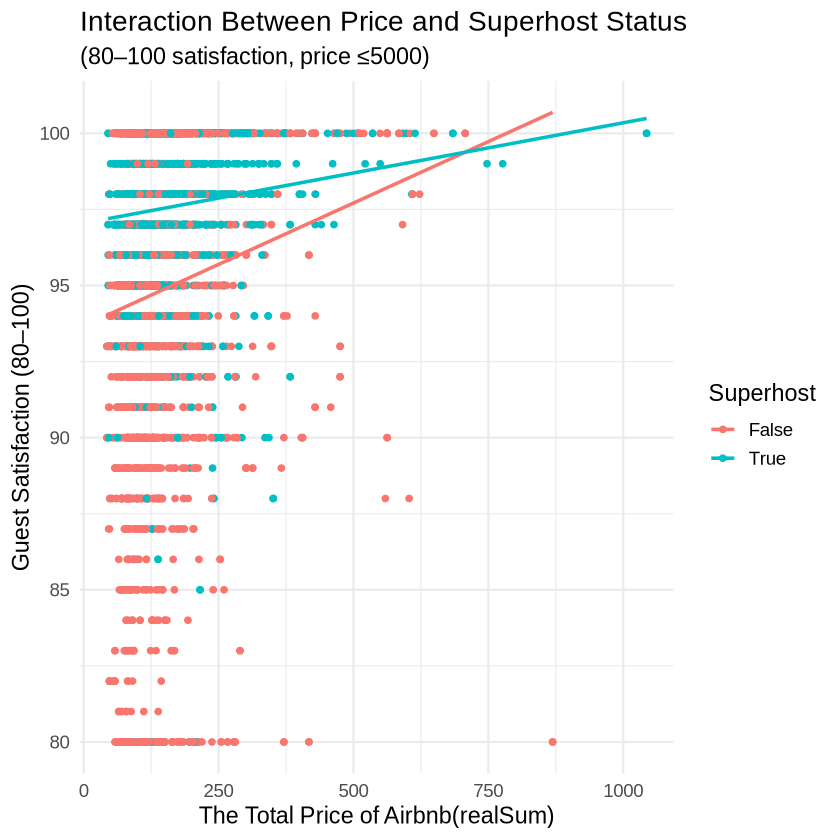

In [7]:
plot_df <- athens_df %>% 
        filter(guest_satisfaction_overall >= 80, 
               guest_satisfaction_overall <= 100, 
               realSum <= 5000)

int_plot <- ggplot(
    plot_df, 
    aes(x = realSum, 
        y = guest_satisfaction_overall, 
        color = host_is_superhost))+ 
    geom_point()+ 
    geom_smooth(method = "lm", se = FALSE)+ 
    labs(title = "Interaction Between Price and Superhost Status", 
         subtitle = "(80–100 satisfaction, price ≤5000)", 
         x = "The Total Price of Airbnb(realSum)", 
         y = "Guest Satisfaction (80–100)", 
         color = "Superhost") + theme_minimal(base_size = 14)
int_plot

##### Interpretation:

From the interactive multiple linear regression model, we found mean guest_satisfaction_overall to be 90.71 for non-Superhost listings when all variables are zero. Once again this scenario is not realistic so this result is not meaningful.

realSum | Non-Superhosts: For non-Superhost listings, and while holding all other variables constant, we found that every one Euro increase in realSum is associated with a 0.012 unit increase in guest_satisfaction_overall. As p=3.2610-10<0.05, we reject the null hypothesis and conclude that there is strong statistical evidence that realSum is associated with guest_satisfaction_overall for non-Superhosts.

host_is_superhostTrue: When realSum = 0, we see that Superhost listings have a guest_satisfaction_overall rating that is 6.03 units higher than non-Superhosts. As p=3.1910-61<0.05, we reject the null hypothesis and conclude that there is extremely strong statistical evidence that Superhosts have a higher intercept than non-Superhosts.

dist: Holding all other variables constant, every one kilometer increase in distance from the city center is associated with a 0.186 unit increase in guest_satisfaction_overall. Looking at its significance, as p=0.20 > 0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that dist is associated with guest_satisfaction_overall.

metro_dist: Holding all other variables constant, every one kilometer increase in distance from the nearest metro station is associated with a 0.489 unit increase in guest_satisfaction_overall. For its significance, as p=0.22>0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that metro_dist is associated with guest_satisfaction_overall.

attr_index_norm: Holding all other variables constant, a one unit increase in attr_index_norm is associated with a 0.00379 unit increase in guest_satisfaction_overall. Looking at its significance, we see that p=0.90>0.05, so we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that attr_index_norm is associated with guest_satisfaction_overall.

rest_index_norm: Holding all other variables constant, a one unit increase in rest_index_norm is associated with a 0.0122 unit increase in guest_satisfaction_overall. Looking at its significance, we see that p=0.33>0.05, so we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that rest_index_norm is associated with guest_satisfaction_overall.

realSum | Superhost: We see that for Superhosts, the slope is 0.01196-0.01168=0.00028. This means that for Superhost listings, every one Euro increase in realSum is associated with a 0.00028 unit increase in guest_satisfaction_overall. As p=1.7710-9<0.05, we reject the null hypothesis and conclude that there is strong statistical evidence that the slopes are different between non-Superhosts and Superhosts.

Looking at the overall fit of the interaction model, we got R2=0.0747, meaning that about 7.47% of the variation in guest_satisfaction_overall is explained by this model. This is slightly higher than the additive model which indicates that including interaction between realSum and host_is_superhostTrue improves the model’s ability to interpret variability in guest_satisfaction_overall. The adjusted R2=0.0734 which is very similar to the R2 value, meaning that the model does not suffer from overfitting. The overall F-test gave us p=2.4410-84 meaning we reject the null hypothesis and conclude that there is very strong statistical evidence that one of the variables is associated with guest_satisfaction_overall.